# Surrogate NN model training

The NN surrogate model aims to replace the following map:
$$\mathbf{f}  : (C, D) \rightarrow Q(x), \quad F(x) = \mathbb{P}(X\le x), \quad x \in \mathbb{R},$$
where
$$\text{iCDF}: Q(p)=F^{-1}(p) = \min\{x\in \mathbb{R}: F(x)\ge p \}, \quad p\in (0,1).$$

Input: $(C, D)$, fracture density $C \in [2.5, 6.5]$, fractal dimension $D \in [1, 1.3]$

Output: discrete $Q(x), F^{-1}(0.01), F^{-1}(0.03), ..., F^{-1}(0.99)$, 50 points in total.

In [1]:
%%capture
!pip install ray
import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [2]:
import pickle as pkl
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
import time
import random
from google.colab import drive
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as T
from functools import partial
from google.colab import files
from datetime import datetime

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
filename  = '/content/drive/MyDrive/RESEARCH_fracture/seeds20/CD_ICDF_LR.pkl'

with open(filename,'rb') as file:
  [C_d, P_cdf] = pkl.load(file, encoding='latin1') 
P_cdf = np.asarray(P_cdf)
C_d = np.asarray(C_d)
train_size = int(len(P_cdf)*0.8)
X, Y = np.asarray(P_cdf[:train_size]), np.asarray(C_d[:train_size])

print('length of input,', len(P_cdf))
print('length of output,', len(C_d))
print('dimension of input,',len(P_cdf[0]))
print('dimension of output,', len(C_d[0]))
print(C_d[0])

## append C^(1/d), C^(-d), C*d, and 1/d to the input array to create more features.
new_cd = np.concatenate(
    (
    C_d, np.array(
        [
          C_d[:,0]**(1/C_d[:,1]),  ## C^(1/d)
          C_d[:,0]**(-C_d[:,1]),   ## C^(-d)
          C_d[:,0]*C_d[:,1],       ## C*d
          1/C_d[:,1],              ## 1/d 
        ]
        ).T
     ), axis=1
)
new_cd.shape

length of input, 10000
length of output, 10000
dimension of input, 50
dimension of output, 2
[10.78862594  2.37419141]


(10000, 6)

## load data

In [4]:
## data loader
def load_data(new_cd, P_cdf, num_training, num_test):
  """
  load training data from the pickled list: new_cd, P_cdf, divide the training 
  and test data to 8:2, the training set will be split again into 8:2 (train/validate) 
  in hyper-parameter tuning stage
  """

  # Subsample the data
  tensor_X = torch.stack([torch.Tensor(np.reshape(i,(6,))) for i in new_cd]) # transform to torch tensors
  tensor_y = torch.stack([torch.Tensor(np.reshape(i,(50,))) for i in P_cdf])

  test_size = num_training + num_test
  X_train = tensor_X[:num_training]
  y_train = tensor_y[:num_training]

  x_test = tensor_X[num_training:test_size]
  y_test = tensor_y[num_training:test_size]

  train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
  test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

  print('loaded data.')
  return train_dataset, test_dataset

trainset, testset = load_data(
    new_cd, P_cdf, 
    num_training=int(len(new_cd)*0.8), 
    num_test=int(len(new_cd)*0.2),
    )

loaded data.


## ray hyperparameter searching

In [5]:
##define Net with flexible number of layers, number of neurons in each layer,
class Net(nn.Module):
    def __init__(self, ls=[20 for i in range(20)], n_l=5):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, ls[0])
        self.linears = nn.ModuleList(
            [nn.Linear(ls[i], ls[i+1]) for i in range(n_l-1)]
            )
        self.fcend = nn.Linear(ls[n_l-1], 50)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
        x = F.relu(self.fcend(x))
        return x

def hel_loss(P, Q):
  return torch.mean(torch.sqrt(torch.sum((torch.sqrt(P) - torch.sqrt(Q))**2, dim=1)))

def train(config, max_num_epochs=1000):
    random.seed(888)
    np.random.seed(888)
    net = Net(config['ls'], config['n_l'])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    net.to(device) 
    # optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
    if config['opt'] == 'rms':
      optimizer = optim.RMSprop(net.parameters(), lr=config["lr"])
    elif config['opt'] == 'sgd':
      optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9, nesterov=True)
    elif config['opt'] == 'ada':
      optimizer = optim.Adagrad(net.parameters(), lr=config["lr"])
    elif config['opt'] == 'adam':
      optimizer = optim.Adam(net.parameters(), lr=config["lr"], betas=(0.9, 0.999), amsgrad=False)

    train_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [train_abs, len(trainset) - train_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=500,
        shuffle=True,
        num_workers=0)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=500,
        shuffle=True,
        num_workers=0)
    
    for epoch in range(max_num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, targets]
          inputs, targets = data
          inputs, targets = inputs.to(device), targets.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = hel_loss(outputs, targets) #use hellinger distance as the loss
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()


      # Validation loss
      val_loss = 0.0
      val_steps = 0

      for i, data in enumerate(valloader, 0):
          with torch.no_grad():
              inputs, targets = data
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = net(inputs)

              loss = hel_loss(outputs, targets)
              # loss = nn.MSELoss()
              # loss = loss(outputs, targets)
              val_loss += loss.cpu().numpy()
              val_steps += 1
      if (epoch+1)%100 == 0:
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps))
    print("Finished Training")
  
def test_loss(net, device="cpu"):

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=len(testset), shuffle=False, num_workers=2)

    with torch.no_grad():
      for data in testloader: #only 1 batch
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        test_loss = nn.MSEloss(outputs, targets)
    return test_loss

In [45]:
def plot_prediction(outputs, targets, inputs, title=''):

    fig1, axs = plt.subplots(len(targets)//4, 4, figsize=(12,8), 
                             sharey = 'row', sharex=True,
                             constrained_layout=True)
    axs = axs.flat
    ylims = [
              [np.min(targets[:4,])-0.2, np.max(targets[:4,])+0.2],
              [np.min(targets[4:,])-0.2, np.max(targets[4:,])+0.2]
    ]
    zeros_ind = outputs==0.   
    for ax, i, out, tar in zip(axs, range(len(outputs)), outputs, targets):
        CD =  inputs[i][:2]
        ax.set_title('p={:.2f}, a={:.2f}'.format(CD[0], CD[1]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, 'o', label='truth')
        ax.plot(x, out, '*', label='prediction')
        ylim = ylims[0] if i<4 else ylims[1]
        if np.any(zeros_ind):
            ax.plot(x[zeros_ind[i]], 
                    [ylim[0]+0.1 for i in range(len(x[zeros_ind[i]]))],
                    'x', color='r', label='zero predictions')

        ax.set_ylim(ylim)
        ax.set_xlabel('ICDF')
    ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    axs[0].set_ylabel('log(partical arrive time)')
    axs[4].set_ylabel('log(partical arrive time)')
    plt.show()
    fig1.savefig(title+'/test.pdf')
    return
def non_decreasing(L):
    return all(x<=y for x,y in zip(L,L[1:]))
def plot_in1(outputs, targets, inputs, title='', fig_title=''):
    assert non_decreasing(targets[0]), 'P_cdf not increasing'

    fig1, ax = plt.subplots(1, 1, figsize=(5,4), constrained_layout=True,)
    for i, out, tar in zip(range(len(outputs)), outputs, targets):
        # ax.set_title('C, d= %s' %str(inputs.cpu().detach().numpy()[i][:2]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, '.', ls ='-', ms=1, label='truth')
        ax.plot(x, out, '*', label='prediction')
    ax.set_ylabel('log(partical arrive time)')
    ax.set_xlabel('ICDF')
    # ax.legend()
    plt.show()
    if fig_title == '':
        fig1.savefig(title+'/test_in1.pdf')
    else:
        fig1.savefig(title+'/'+fig_title+'.pdf')
    return

### If training again

In [ ]:
now = datetime.now() # current date and time
filename = now.strftime("%m-%d-%Y-%H-%M-%S")
path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'+filename
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
! rm -rf ~/ray_results
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)
random.seed(888)
np.random.seed(888)
start = time.time()
num_samples=2500
gpus_per_trial=0.2
# trainset, testset = load_data(
#     new_cd, P_cdf, 
#     num_training=int(len(new_cd)*0.8), 
#     num_test=int(len(new_cd)*0.2),
#     )
config = {
    "n_l": tune.sample_from(lambda _: np.random.randint(3, 7)),
    # "ls": [tune.choice([100, 200, 500]) for i in range(5)],
    "ls": [tune.sample_from(lambda _: 2 ** np.random.randint(4, 10)) for i in range(7)],
    "lr": tune.loguniform(1e-4, 1e-2),
    # "batch_size": tune.choice([100, 200, 500]),
    "opt": tune.choice(['rms', 'sgd', 'ada', 'adam']),
}
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=1000,
    grace_period=1,
    reduction_factor=2
    )
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "training_iteration"])
result = tune.run(
    partial(train,),
    resources_per_trial={"cpu": 1, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
best_trial.last_result["loss"]))

best_trained_model = Net(
    ls=best_trial.config["ls"],
    n_l=best_trial.config["n_l"],
    )
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if gpus_per_trial > 1:
        best_trained_model = nn.DataParallel(best_trained_model)
best_trained_model.to(device)

best_checkpoint_dir = best_trial.checkpoint.dir_or_data
model_state, optimizer_state = torch.load(best_checkpoint_dir+"/checkpoint")
best_trained_model.load_state_dict(model_state)

print('time: ', time.time()-start)


torch.save(
    {
        # 'max_num_epochs': max_num_epochs,
        'model_state_dict': best_trained_model.state_dict(),
        'loss': best_trial.last_result["loss"],
        'Best trial config': best_trial.config,
    },
    path+'/ckp.pt'
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#when edit the output in the dataset
print('ls', best_trial.config["ls"])
print('n_l', best_trial.config["n_l"])
print('opt', best_trial.config["opt"])
# print('batch_size', best_trial.config["batch_size"])
print(best_trial.last_result["loss"])

ls [512, 256, 256, 128, 512, 32, 512]
n_l 3
opt adam
0.11791874468326569


In [ ]:
best_trained_model

Net(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fcend): Linear(in_features=256, out_features=50, bias=True)
)

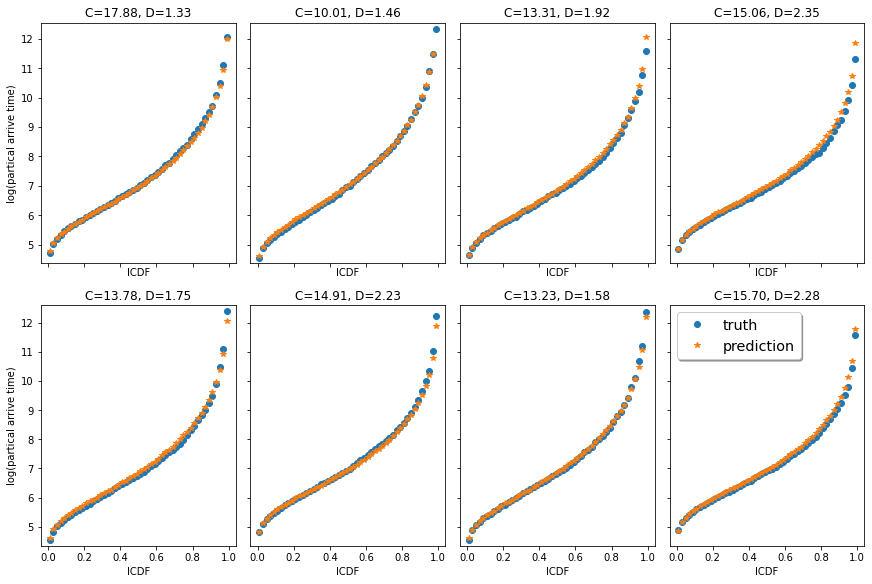

In [ ]:
test_ind = np.random.randint(0, len(testset),8)
with torch.no_grad():
    inputs, targets = testset[test_ind]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)

plot_prediction(outputs.cpu().numpy(), targets.cpu().numpy(), inputs, title=path)

In [ ]:
dfs = result.fetch_trial_dataframes()
for key in dfs.keys():
  log = dfs[key]
  print(log.keys())

Streaming output truncated to the last 5000 lines.
       'iterations_since_restore', 'warmup_time'],
      dtype='object')
Index(['loss', 'time_this_iter_s', 'should_checkpoint', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration', 'trial_id',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'warmup_time'],
      dtype='object')
Index(['loss', 'time_this_iter_s', 'should_checkpoint', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration', 'trial_id',
       'experiment_id', 'date', 'timestamp', 'time_total_s', 'pid', 'hostname',
       'node_ip', 'time_since_restore', 'timesteps_since_restore',
       'iterations_since_restore', 'warmup_time'],
      dtype='object')
Index(['loss', 'time_this_iter_s', 'should_checkpoint', 'done',
       'timesteps_total', 'episodes_total', 'training_iteration', 'trial_id',
       'ex

### If results **saved**

In [46]:
path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'
files = os.listdir(path)
folders = [os.path.join(path, i) for i in files if '.' not in i]
latest_folder = max(folders, key=os.path.getctime)
latest_folder='/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37'
print(latest_folder)
check_data = torch.load(latest_folder+'/ckp.pt')

best_config = check_data['Best trial config']
best_trained_model = Net(ls=best_config['ls'], n_l=best_config['n_l'])
best_trained_model.load_state_dict( check_data['model_state_dict'])
print(best_trained_model)
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
best_trained_model = best_trained_model.to(device)


/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37
Net(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fcend): Linear(in_features=256, out_features=50, bias=True)
)


In [47]:
train_dataset, test_dataset = load_data(
    new_cd, P_cdf, 
    num_training=int(len(new_cd)*0.8), 
    num_test=int(len(new_cd)*0.2)
    )

loaded data.


In [48]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
test_loss = 0.
test_steps = 0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_trained_model(inputs)

        loss = hel_loss(outputs, targets)
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        test_loss += loss.cpu().numpy()
        test_steps += 1
print(test_loss/test_steps)

0.11781509779393673


### continue training from the best checkpoint

In [49]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
print('training on device:', device)
best_trained_model.to(device) 
# optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
if best_config['opt'] == 'rms':
    optimizer = optim.RMSprop(best_trained_model.parameters(), lr=best_config["lr"])
elif best_config['opt'] == 'sgd':
    optimizer = optim.SGD(best_trained_model.parameters(), lr=best_config["lr"], momentum=0.9, nesterov=True)
elif best_config['opt'] == 'ada':
    optimizer = optim.Adagrad(best_trained_model.parameters(), lr=best_config["lr"])
elif best_config['opt'] == 'adam':
    optimizer = optim.Adam(best_trained_model.parameters(), lr=best_config["lr"], betas=(0.9, 0.999), amsgrad=False)

scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 100, factor=0.5, verbose=True)

train_abs = int(len(trainset) * 0.8)
train_subset, val_subset = random_split(
    trainset, [train_abs, len(trainset) - train_abs])

trainloader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
valloader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=500,
    shuffle=True,
    num_workers=0)

max_num_epochs = 1000
train_loss = []
validation_loss = []
for epoch in range(max_num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    best_trained_model.train()
    train_steps = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, targets]
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = best_trained_model(inputs)
        loss = hel_loss(outputs, targets) #use hellinger distance as the loss
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_steps += 1
    train_loss.append(running_loss/train_steps)    

    # Validation loss
    val_loss = 0.0
    val_steps = 0
    best_trained_model.eval()
    for i, data in enumerate(valloader, 0):
        with torch.no_grad():
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = best_trained_model(inputs)

            loss = hel_loss(outputs, targets)
            # loss = nn.MSELoss()
            # loss = loss(outputs, targets)
            val_loss += loss.cpu().numpy()
            val_steps += 1
    validation_loss.append(val_loss / val_steps)
    if (epoch+1)%500 == 0:
        print(val_loss / val_steps)
    scheduler.step(val_loss)

training on device: cuda:0
Epoch 00130: reducing learning rate of group 0 to 1.1503e-03.
Epoch 00287: reducing learning rate of group 0 to 5.7516e-04.
Epoch 00401: reducing learning rate of group 0 to 2.8758e-04.
0.09763358719646931
Epoch 00505: reducing learning rate of group 0 to 1.4379e-04.
Epoch 00606: reducing learning rate of group 0 to 7.1895e-05.
Epoch 00807: reducing learning rate of group 0 to 3.5947e-05.
Epoch 00908: reducing learning rate of group 0 to 1.7974e-05.
0.09578239731490612


In [50]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=500,
    shuffle=True,
    num_workers=0)
test_loss = 0.
test_steps = 0
for i, data in enumerate(test_loader, 0):
    with torch.no_grad():
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_trained_model(inputs)

        loss = hel_loss(outputs, targets)
        # loss = nn.MSELoss()
        # loss = loss(outputs, targets)
        test_loss += loss.cpu().numpy()
        test_steps += 1
print('testing loss: ', test_loss/test_steps)

testing loss:  0.0959586352109909


In [51]:
with open(path+'training_stats.pkl', 'wb') as file:
    pkl.dump([train_loss, validation_loss, test_loss/test_steps], file)

[0.09938323 0.06520971 0.08051666 0.05819619 0.09283526 0.05786145
 0.13659117 0.08881786]


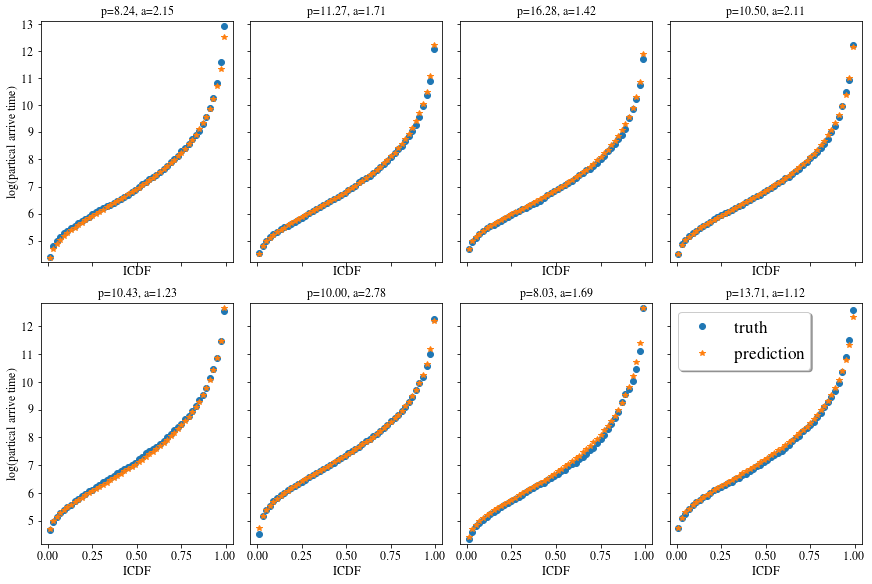

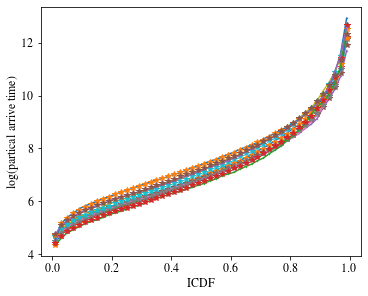

In [52]:
path = latest_folder + '/continue_train'
if not os.path.exists(path):
    os.makedirs(path)
torch.save(
    {
        # 'max_num_epochs': max_num_epochs,
        'model_state_dict': best_trained_model.state_dict(),
    },
    path+'/ckp.pt'
)

np.random.seed(88)
with torch.no_grad():
    inputs, targets = test_dataset[[np.random.randint(0, len(test_dataset), size=(8,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
plot_prediction(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)
plot_in1(outputs.cpu(), targets.cpu(), inputs, title=path)

##plot illpose

In [53]:
%%capture
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [54]:
## find the bound of the ICDF as input
min_list = [P_cdf[i][0] for i in range(len(P_cdf))]
max_list = [P_cdf[i][-1] for i in range(len(P_cdf))]
print('minimal starting P_cdf is:', min(min_list))
print('maximal ending P_cdf is:', max(max_list))
print(P_cdf[0])
print(P_cdf[1])
# for i in range(len(P_cdf)):
#   P_cdf[i] = np.fft.fft(P_cdf[i])
# print(P_cdf[0])
# print(P_cdf[1])

minimal starting P_cdf is: 4.078765780698708
maximal ending P_cdf is: 13.936552506069377
[ 4.63088979  4.98481573  5.22284257  5.31684898  5.44540919  5.51935828
  5.61520821  5.75478437  5.83994643  5.93033708  6.02945253  6.12179045
  6.18673785  6.26771637  6.34572447  6.41410892  6.49724759  6.56697345
  6.66236247  6.73702824  6.79538951  6.88001564  6.95466739  7.04535337
  7.11954745  7.24377954  7.35834419  7.47606163  7.54649811  7.67078958
  7.77103233  7.8332761   7.95480841  8.04271449  8.14877621  8.26751691
  8.4202671   8.54810628  8.67725571  8.81302448  8.96580023  9.1370591
  9.32028063  9.55210884  9.81219724 10.07008815 10.40731714 11.03665208
 11.50442879 12.88586131]
[ 4.54640214  4.81736783  4.94509411  5.09898252  5.23318729  5.29477774
  5.41371457  5.48676999  5.578864    5.6551053   5.7532378   5.8118937
  5.88694579  5.95607911  6.02027008  6.0919586   6.17160783  6.24609052
  6.35569791  6.42903384  6.52040967  6.57719627  6.68454901  6.77344485
  6.8553362

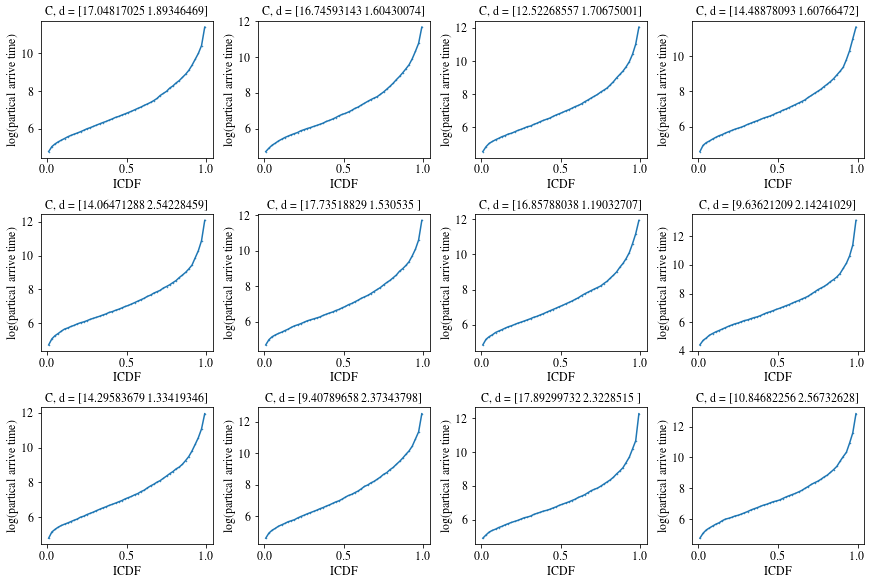

In [55]:
fig1, axs = plt.subplots(3, 4, figsize=(12,8), constrained_layout=True)
axs = axs.flat
np.random.seed(88)
rand_i = np.random.randint(0, high = len(X), size = 12)

for i, ax in zip(range(12), axs):
    ax.set_title('C, d = %s' %str(Y[rand_i[i]]))
    x = np.linspace(0.01, 0.99, 50)
    y = X[rand_i[i]]
    ax.plot(x, y, '.', ls='-', ms=1)
    ax.set_ylabel('log(partical arrive time)')
    ax.set_xlabel('ICDF')

In [56]:
path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'

In [57]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font',**{'family':'serif','serif':['Times']})
plt.rcParams['text.usetex'] = True
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)


mse time:  0.08134126663208008
hellinger time:  0.10672259330749512
mse time:  0.07691645622253418
hellinger time:  0.10596895217895508
mse time:  0.07520151138305664
hellinger time:  0.10273933410644531


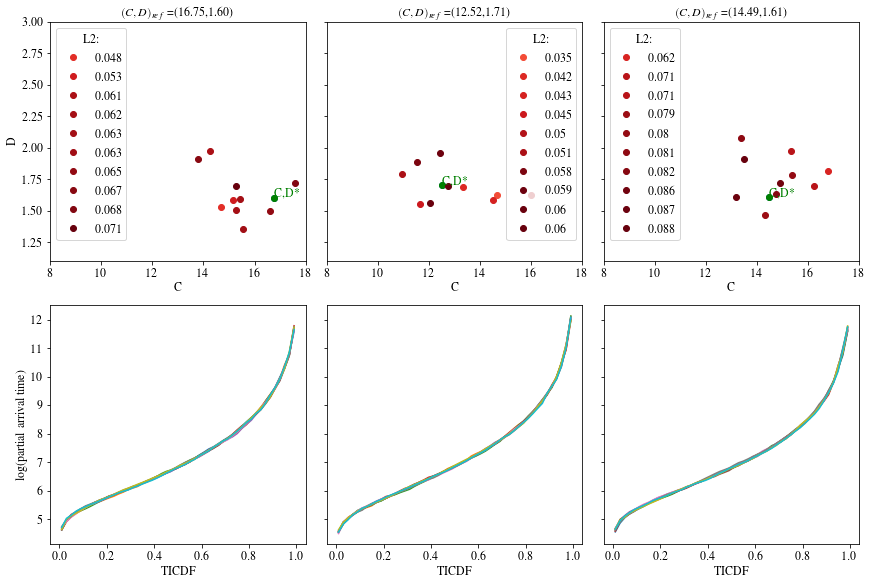

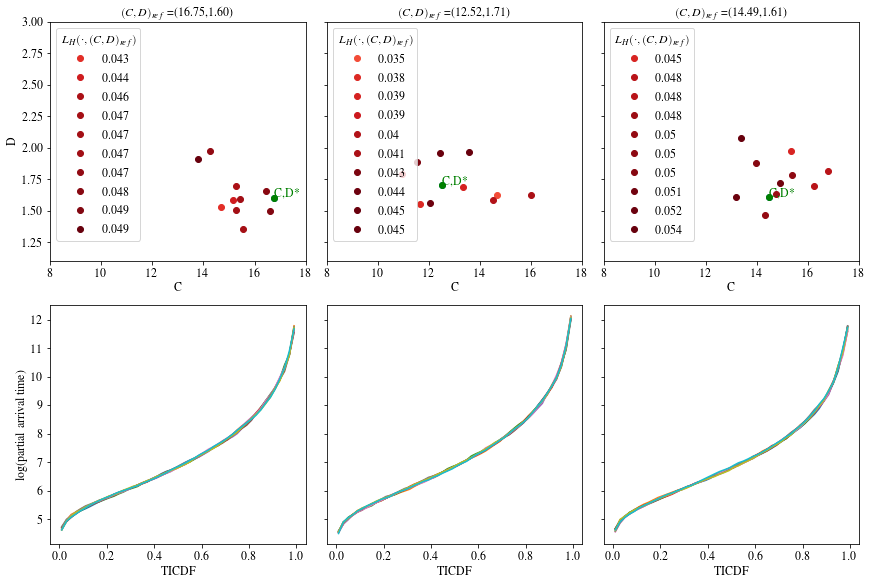

In [58]:
##calculate the hellinger loss of all cdfs with the first cdf
def hel_dist(P, Q):
  return np.sqrt(sum((np.sqrt(P) - np.sqrt(Q))**2))

# fig.savefig('C_d.pdf', format='pdf',bbox_inches='tight')
np.random.seed(88)
ind = np.random.randint(1, 10001, 6)-1
fig, axs = plt.subplots(2, 3, figsize=(12, 8),  sharey='row',
                             constrained_layout=True)
fig2, axs2 = plt.subplots(2,3, figsize=(12, 8),  sharey='row',
                             constrained_layout=True)
for k in range(3):
  mse_cdf = np.zeros((len(P_cdf)))
  hel_dists = np.zeros((len(P_cdf)))
  time1 = time.time()
  for i in range(len(P_cdf)):
    mse_cdf[i] = sum((P_cdf[i] - P_cdf[ind[k]])**2)
  time2 = time.time()
  print('mse time: ', time2-time1)
  time1 = time.time()
  for i in range(len(P_cdf)):
    hel_dists[i] = hel_dist(P_cdf[i], P_cdf[ind[k]])
  time2 = time.time()
  print('hellinger time: ', time2-time1)
  min_cdf_10 = np.argpartition(mse_cdf, 11)
  min_hel_10 = np.argpartition(hel_dists, 11)

  dist = mse_cdf[min_cdf_10[:11]]
  ind_dist = np.argsort(dist)
  min10 = C_d[min_cdf_10[:11]]
  dist, min10 = dist[ind_dist], min10[ind_dist]
  y1 = min10[:,0]
  y2 = min10[:,1]
  dist_hel = hel_dists[min_hel_10[:11]]
  ind_dist_hel = np.argsort(dist_hel)
  min10_hel = C_d[min_hel_10[:11]]
  dist_hel, min10_hel = dist_hel[ind_dist_hel], min10_hel[ind_dist_hel]
  y1_hel = min10_hel[:,0]
  y2_hel = min10_hel[:,1]
  axs[0,k].plot(y1[0], y2[0], "o")
  axs2[0,k].plot(y1_hel[0], y2_hel[0], 'o')
  color_map = plt.get_cmap("Reds")
  norm = mpl.colors.Normalize(vmin=min(dist), vmax=max(dist))
  for i,txt in enumerate(dist):
      if y1[i] == C_d[ind[k], 0] and y2[i] == C_d[ind[k], 1]:
        axs[0,k].plot(y1[i], y2[i], "o", color = 'g', )
        axs[0,k].annotate('{C,D}*', (C_d[ind[k], 0], C_d[ind[k], 1]), color = 'g')
      else:
        axs[0,k].plot(y1[i], y2[i], "o", color = color_map(norm(txt)), 
                      label=round(txt, 3))

      if y1_hel[i] == C_d[ind[k], 0] and y2_hel[i] == C_d[ind[k], 1]:
        axs2[0,k].plot(y1_hel[i], y2_hel[i], "o", color = 'g')
        axs2[0,k].annotate('{C,D}*', (C_d[ind[k], 0], C_d[ind[k], 1]), color = 'g')
      else:
        axs2[0,k].plot(y1_hel[i], y2_hel[i], "o", color = color_map(norm(txt)),
              label=round(dist_hel[i], 3))
  axs[0,k].legend(title='L2:')
  axs[0,k].set_xlabel("C")
  axs[0,k].set_xlim(8, 18)
  axs[0,k].set_title(
      "$(C,D)_{ref}$" + " =({:.2f},{:.2f})".format(C_d[ind[k], 0], C_d[ind[k], 1])
      )
      # r"\ is Number $\displaystyle\sum_{n=1}^\infty\frac{-e^{i\pi}}{2^n}$!",
      # fontsize=16, color='r')
  axs2[0,k].legend(title='$L_H(\cdot, (C,D)_{ref})$')
  axs2[0,k].set_xlabel("C")
  axs2[0,k].set_xlim(8, 18)
  #guofeng modified
  axs2[0,k].set_title(
      "$(C,D)_{ref}$" + " =({:.2f},{:.2f})".format(C_d[ind[k], 0], C_d[ind[k], 1])
      )
  for j in range(10):
    axs[1,k].plot(np.linspace(0.01, 0.99, 50), P_cdf[min_cdf_10[j]])
    axs[1,k].set_xlabel('TICDF')
    axs2[1,k].plot(np.linspace(0.01, 0.99, 50), P_cdf[min_hel_10[j]])
    axs2[1,k].set_xlabel('TICDF')
axs[0,0].set_ylabel("D")
axs[0,0].set_ylim(1.1,3)
axs2[0,0].set_ylabel("D")
axs2[0,0].set_ylim(1.1,3)
axs[1,0].set_ylabel('log(partial arrival time)')
axs2[1,0].set_ylabel('log(partial arrival time)')
# fig.suptitle('L2 distance')
# fig2.suptitle('Hellinger')    
fig.savefig(path+'illpose.pdf', format='pdf',bbox_inches='tight')
fig2.savefig(path+'illpose_hellinger.pdf', bbox_inches='tight')

In [59]:
print('how many gpu: ', torch.cuda.device_count())
# USE_GPU = False
USE_GPU = True
dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', torch.cuda.get_device_name())

how many gpu:  1
using device: Tesla T4


## grid searching

In [60]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

path = '/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/'
files = os.listdir(path)
folders = [os.path.join(path, i) for i in files if '.' not in i]
latest_folder = max(folders, key=os.path.getmtime)
latest_folder='/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37'
print(latest_folder)
check_data = torch.load(latest_folder+'/ckp.pt')
best_config = check_data['Best trial config']
best_trained_model = Net(ls=best_config['ls'], n_l=best_config['n_l']).to(device)


continue_path = latest_folder + '/continue_train'
dict_data = torch.load(continue_path+'/ckp.pt')
best_trained_model.load_state_dict( dict_data['model_state_dict'])
print(best_trained_model)

/content/drive/MyDrive/RESEARCH_fracture/net_files/checkpoint_corrected/01-07-2023-16-12-37
Net(
  (fc1): Linear(in_features=6, out_features=512, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (fcend): Linear(in_features=256, out_features=50, bias=True)
)


In [61]:
os.getcwd()

'/content'

[0.09938323 0.06520971 0.08051666 0.05819619 0.09283526 0.05786145
 0.13659117 0.08881786]


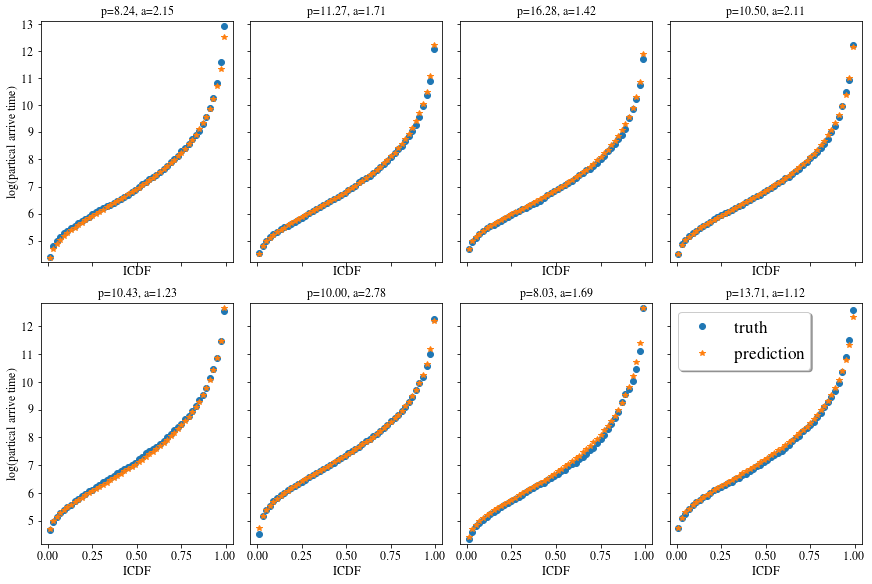

In [62]:
np.random.seed(88)
with torch.no_grad():
    inputs, targets = testset[[np.random.randint(0, len(testset), size=(8,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
plot_prediction(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)

In [71]:
def plot_prediction1(outputs, targets, inputs, title=''):

    fig1, axs = plt.subplots(len(targets)//4, 4, figsize=(12,4), 
                             sharey = 'row', sharex=True,
                             constrained_layout=True)
    axs = axs.flat
    ylims = [
              [np.min(targets[:4,])-0.2, np.max(targets[:4,])+0.2],
              #[np.min(targets[4:,])-0.2, np.max(targets[4:,])+0.2]
    ]
    zeros_ind = outputs==0.   
    for ax, i, out, tar in zip(axs, range(len(outputs)), outputs, targets):
        CD =  inputs[i][:2]
        ax.set_title('p={:.2f}, a={:.2f}'.format(CD[0], CD[1]))
        x = np.linspace(0.01, 0.99, 50)
        ax.plot(x, tar, 'o', label='truth')
        ax.plot(x, out, '*', label='prediction')
        ylim = ylims[0] if i<4 else ylims[1]
        if np.any(zeros_ind):
            ax.plot(x[zeros_ind[i]], 
                    [ylim[0]+0.1 for i in range(len(x[zeros_ind[i]]))],
                    'x', color='r', label='zero predictions')

        ax.set_ylim(ylim)
        ax.set_xlabel('ICDF')
        if i==0:
          ax.legend(loc='upper left', shadow=True, fontsize='x-large')
    axs[0].set_ylabel('log(partical arrive time)')
    #axs[4].set_ylabel('log(partical arrive time)')
    plt.show()
    fig1.savefig(title+'/test1.pdf')
    fig1.savefig(title+'/test1.png')
    return

[0.09938323 0.06520971 0.08051666 0.05819619]


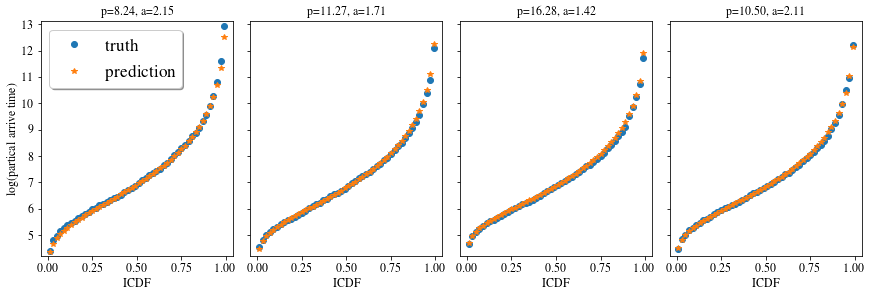

In [72]:
np.random.seed(88)
with torch.no_grad():
    inputs, targets = testset[[np.random.randint(0, len(testset), size=(4,))]]
    inputs, targets = inputs.to(device), targets.to(device)
    best_trained_model.eval()
    outputs = best_trained_model(inputs)
print(np.sqrt(np.sum((np.sqrt(outputs.cpu().numpy()) - np.sqrt(targets.cpu().numpy()))**2, axis=1)))
plot_prediction1(outputs.cpu().numpy(), targets.cpu().numpy(), inputs.cpu().numpy(), title=path)

In [73]:
sig = 0.4

In [74]:
start = time.time()
## grid searching
C = np.linspace(8, 18, 10000)
# D = k*C +b
D = np.linspace(1.1, 3, 1000)
C, D = np.meshgrid(C, D)
mesh_shape = C.shape
C, D = np.reshape(C,(-1,)), np.reshape(D, (-1))
all_pairs = np.array([C, D, C**(1/D), C**(-D), C*D, 1/D]).T
best_trained_model.eval()
all_outputs = torch.FloatTensor([]).to(device)
batch_size = 50000
with torch.no_grad():
    for i in range(0, len(all_pairs), batch_size):
        if i+batch_size < len(all_pairs):
            batch = all_pairs[i:i+batch_size]
        else:
            batch = all_pairs[i:]
        batch_input = torch.FloatTensor(batch).to(device)
        outputs = best_trained_model(batch_input)
        all_outputs = torch.cat((all_outputs, outputs), 0)

end1 = time.time()


[1876  876  724]


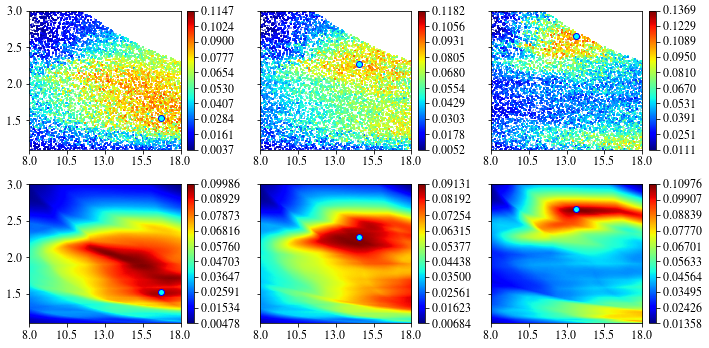

In [85]:
np.random.seed(111)
ind = np.random.randint(0, len(testset), size=3)
print(ind)
fig, axs = plt.subplots(2, 3, figsize=(10, 5),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
    ## plot the scatter plot with the dataset:
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))
    ax = axs[i_ind]
    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )

    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    #if i_ind==0:
      #ax.legend(shadow=True,loc='upper left')

    ## plot the map with the nn surrogate
    ax = axs[i_ind+3]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    #if i_ind==0:
      #ax.legend(shadow=True,loc='upper left')
#axs[2].legend(shadow=True,loc='upper left')
#ax.legend(shadow=True,loc='upper right')
plt.tight_layout()
fig.savefig(continue_path+'/posterior1.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

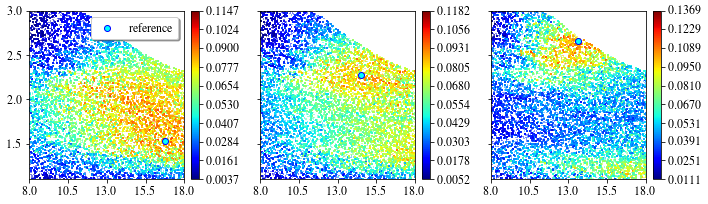

In [88]:
## postrior with the orginal dataset

## grid searching
# P_cdf = np.asarray(P_cdf)
# C_d = np.asarray(C_d)

fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row', sharex='col')

for i, ax in zip(ind, axs.flat):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].cpu().numpy()
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/101)*(1.9/101))

    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
                        # interpolation='nearest',
              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
              vmin=p.min(), vmax = p.max(),
              # origin='lower',aspect='auto'
              )
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('p [-]')
    # ax.set_ylabel('a [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    if i==1876:
      ax.legend(shadow=True, loc='upper right')

    # ax1.set_ylim([0, 12])
    # ax.set_xlabel('p [-]')
    # ax.set_ylabel('a [-]')
plt.tight_layout()
fig.savefig(continue_path+'/density_sparse.pdf', format='pdf',bbox_inches='tight')
plt.show()
# end2 = time.time()

16.726762771606445 1.5280492305755615
14.52927017211914 2.275987148284912
13.623912811279297 2.6573562622070312


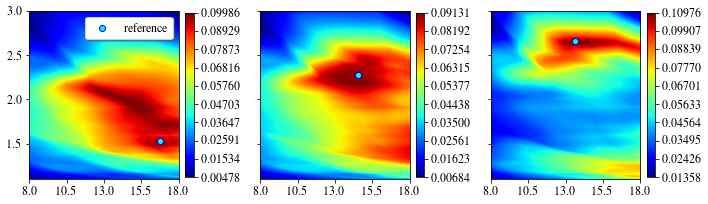

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3),  sharey='row',)
axs = axs.flat
for i_ind, i in enumerate(ind):
    ref_C = testset[i][0][0].cpu().numpy().item() ## C
    ref_D = testset[i][0][1].cpu().numpy().item()
    ref_input = testset[i][0].to(device)
    
    ## plot the scatter plot with the dataset:
#    with torch.no_grad():
#        # ref_out = best_trained_model(ref_input)
##        ref_out = testset[i][1].cpu().numpy()
#        # ref_out = ref_out.cpu().detach().numpy()
#        all_hel_loss = np.sqrt(np.sum((np.sqrt(P_cdf) - np.sqrt(ref_out))**2, axis=1))
#    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
#    p = p/np.sum(p*(10/101)*(1.9/101))
#    ax = axs[i_ind]
##    c01map = ax.scatter(C_d[:,0], C_d[:,1], c=p, cmap='jet', marker=",", s = 0.5,
#                        # interpolation='nearest',
#              # extent=[C_d[:,0].min(), C_d[:,0].max(), C_d[:,1].min(), C_d[:,1].max()],
 #             vmin=p.min(), vmax = p.max(),
 #             # origin='lower',aspect='auto'
 #             )
#
 #   ax.set_xlim(8, 18)
 #   ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
 #   ax.set_ylim(1.1, 3)
 #   # ax.set_xlabel('C [-]')
 #   # ax.set_ylabel('D [-]')
 #   v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
 #   fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
 #   ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')

    ## plot the map with the nn surrogate
    ax = axs[i_ind]
    with torch.no_grad():
        # ref_out = best_trained_model(ref_input)
        ref_out = testset[i][1].to(device)
        # ref_out = ref_out.cpu().detach().numpy()
        all_hel_loss = torch.sqrt(torch.sum((torch.sqrt(all_outputs) - torch.sqrt(ref_out))**2, dim=1))
    all_hel_loss = all_hel_loss.data.cpu().numpy()
    p = 1/(sig*np.sqrt(2*np.pi))*np.exp(-all_hel_loss/(2*sig**2))
    p = p/np.sum(p*(10/9999)*(1.9/999))
    p = np.reshape(p, mesh_shape)
    c01map = ax.imshow(p, cmap='jet', interpolation='nearest',
              extent=[C.min(), C.max(), D.min(), D.max()],
              vmin=p.min(), vmax = p.max(),
              origin='lower',aspect='auto')
    ax.set_xlim(8, 18)
    ax.set_xticks(np.linspace(8, 18, 5, endpoint=True))
    ax.set_ylim(1.1, 3)
    # ax.set_xlabel('C [-]')
    # ax.set_ylabel('D [-]')
    v1 = np.linspace(np.min(p), np.max(p), 10, endpoint=True)
    fig.colorbar(c01map, ax=ax, fraction=0.05, pad=0.04,ticks=v1,)
    ax.scatter(ref_C, ref_D, c='aqua',edgecolors='b',label='reference')
    print(ref_C,ref_D)
    if i_ind==0:
      ax.legend(shadow=True,loc='upper right')
#axs[2].legend(shadow=True,loc='upper left')
#ax.legend(shadow=True,loc='upper left')
plt.tight_layout()
fig.savefig(continue_path+'/posterior3.pdf', format='pdf',bbox_inches='tight')
plt.show()
end2 = time.time()

In [ ]:
print('run {} forward simulations needs {:.2f} seconds'.format(len(all_hel_loss), end1-start))
print('compute the posterior for 6 simulations and plotting takes {:.2f} seconds'.format(end2-end1))

run 10000 forward simulations needs 8.39 seconds
compute the posterior for 6 simulations and plotting takes 33.51 seconds
